Este script recorre todos los archivos `.csv` de una carpeta que contienen registros de señales crudas del sensor de pulso (canal IR),
aplica distintos filtros para eliminar ruido, detecta picos correspondientes a latidos y estima la frecuencia cardíaca
a partir de los intervalos entre picos.

## Data set SpO2 = 95% y 80 BPM

### 1. Carga de datos

   Tiempo (ms)     IR  AMB_IR    RED  AMB_RED
0            0      0       0  28079        0
1           16  46038   11857  29800    11838
2           33  46188   11938  29966    11922
3           50  46308   12005  30112    11990
4           66  46407   12044  30269    12034


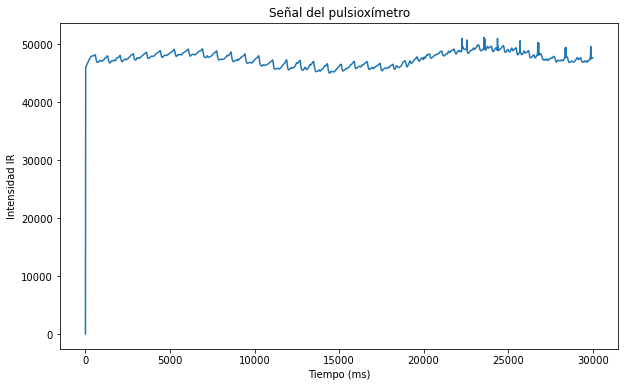

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo CSV
ruta_csv = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_80.csv"
df = pd.read_csv(ruta_csv)

# Mostrar las primeras filas
print(df.head())

# Graficar la señal IR para ver su forma
plt.figure(figsize=(10,6))
plt.plot(df["Tiempo (ms)"], df["IR"])
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad IR")
plt.title("Señal del pulsioxímetro")
plt.show()


## 2. Preprocesamiento de la señal


Antes de detectar los picos de la señal hay que suavizar la señal, eliminar el ruido y los artefactos que pueda haber. 

### Filtrado con media móvil (simple)

In [2]:
# df["IR_filtrado"] = df["IR"].rolling(window=5, center=True).mean()

# plt.figure(figsize=(10,6))
# plt.plot(df["Tiempo (ms)"], df["IR"], label="Original", alpha=0.5)
# plt.plot(df["Tiempo (ms)"], df["IR_filtrado"], label="Filtrado", linewidth=2)
# plt.legend()
# plt.title("Señal IR filtrada")
# plt.show()


### Filtro Butterworth

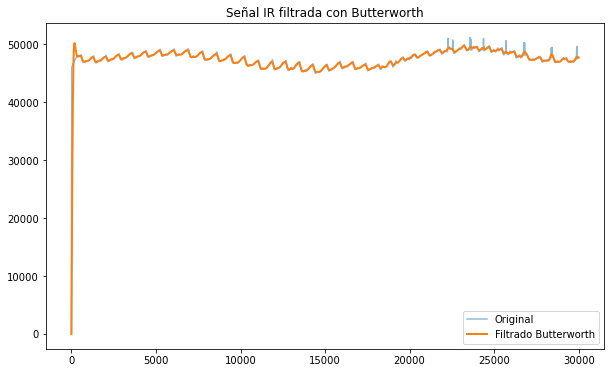

In [3]:
from scipy.signal import butter, filtfilt

# Función para aplicar un filtro pasa-bajos
def butter_lowpass_filter(data, cutoff=3, fs=35, order=2):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

df["IR_filtrado"] = butter_lowpass_filter(df["IR"], cutoff=3, fs=60)

plt.figure(figsize=(10,6))
plt.plot(df["Tiempo (ms)"], df["IR"], alpha=0.5, label="Original")
plt.plot(df["Tiempo (ms)"], df["IR_filtrado"], label="Filtrado Butterworth", linewidth=2)
plt.legend()
plt.title("Señal IR filtrada con Butterworth")
plt.show()


### 3. Detección de picos (latidos)
La frecuencia cardíaca se calcula detectando los picos de la señal filtrada, que corresponden a los latidos del corazón.

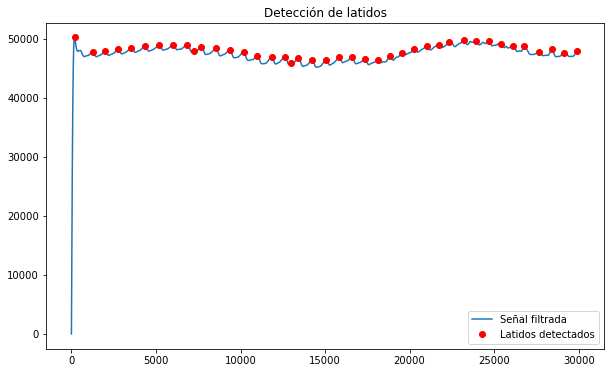

In [4]:
from scipy.signal import find_peaks

fs = 47  # Define la frecuencia de muestreo en Hz
        # Si deteccta pocos picos --> reducir fs
        # Si detecta muchos picos --
# Detectar los picos (latidos)
peaks, _ = find_peaks(df["IR_filtrado"], distance=fs/2, height=0.5)  # Ajusta 'height' según la amplitud

# Graficar los picos detectados
plt.figure(figsize=(10,6))

plt.plot(df["Tiempo (ms)"], df["IR_filtrado"], label="Señal filtrada")
plt.plot(df["Tiempo (ms)"][peaks], df["IR_filtrado"][peaks], "ro", label="Latidos detectados")
plt.legend()
plt.title("Detección de latidos")
plt.show()


## 4. Calcular la Frecuencia Cardíaca (BPM)
Ahora, calculamos el tiempo entre picos y lo convertimos en latidos por minuto (BPM).

In [5]:
import numpy as np

# Calcular los intervalos entre picos en segundos
intervalos = np.diff(df["Tiempo (ms)"][peaks]) / 1000  # Convertir ms a s

# Calcular BPM promedio
bpm = 60 / np.mean(intervalos)
print(f"Frecuencia cardíaca estimada: {bpm:.2f} BPM")


Frecuencia cardíaca estimada: 80.77 BPM


La frecuencia calculada debería de ser de 80 BPM

Aunque la estimación está cerca de la frecuencia esperada, voy a ver si podemos acercarnos más al objetivo. 

**Ajuste del filtrado**\
El filtro Butterworth puede estar afectando la forma de la señal. Voy a probar un filtro de banda en lugar de un pasa-bajos para enfocarme solo en las frecuencias de interés (0.5-3 Hz, que corresponden a 30-180 BPM).

**Ajustar la detección de picos**\
Parece que find_peaks() detecta más picos de los esperados. Voy a ajustar los parámetros:

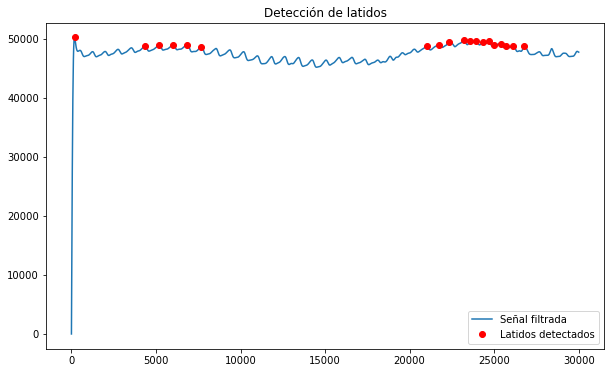

In [6]:
peaks, _ = find_peaks(df["IR_filtrado"], distance=fs/3, height=np.percentile(df["IR_filtrado"], 80))

plt.figure(figsize=(10,6))

plt.plot(df["Tiempo (ms)"], df["IR_filtrado"], label="Señal filtrada")
plt.plot(df["Tiempo (ms)"][peaks], df["IR_filtrado"][peaks], "ro", label="Latidos detectados")
plt.legend()
plt.title("Detección de latidos")
plt.show()


In [7]:
import numpy as np

# Calcular los intervalos entre picos en segundos
intervalos = np.diff(df["Tiempo (ms)"][peaks]) / 1000  # Convertir ms a s

# Calcular BPM promedio
if len(intervalos) > 0:
    bpm = 60 / np.median(intervalos)  # Mediana en lugar de media
print(f"Frecuencia cardíaca estimada: {bpm:.2f} BPM")


Frecuencia cardíaca estimada: 97.24 BPM


- Si detecta más picos de la cuenta, reducir distance en find_peaks():
- Si detecta pocos picos, aumentar distance y height.

El parámetro distance en find_peaks() define la distancia mínima entre picos (en número de muestras), lo que ayuda a evitar detecciones falsas. Para encontrar un valor óptimo, se puede calcular basandose en la frecuencia esperada de los latidos.


In [8]:
tiempos = np.diff(df["Tiempo (ms)"]) / 1000  # Diferencia entre cada muestra en segundos
fs_real = 1 / np.mean(tiempos)  # Frecuencia de muestreo real
print(f"Frecuencia de muestreo real: {fs_real:.2f} Hz")


Frecuencia de muestreo real: 60.04 Hz


In [9]:
bpm_esperado = 80  # Frecuencia cardíaca esperada en BPM
fs_real = 60  # Asegúrate de calcular fs_real antes si puede variar

distance_optimo = fs_real / (bpm_esperado / 60)
print(f"Valor óptimo de distance: {distance_optimo:.2f}")


Valor óptimo de distance: 45.00


# Data set SpO2 = 95% y 99 BPM

   Tiempo (ms)     IR  AMB_IR    RED  AMB_RED
0            0      0       0  65521        0
1           16  14653   41218  65521    41188
2           33  13840   40341  65521    40393
3           50  13198   39655  65521    39704
4           66  12742   39154  65521    39133


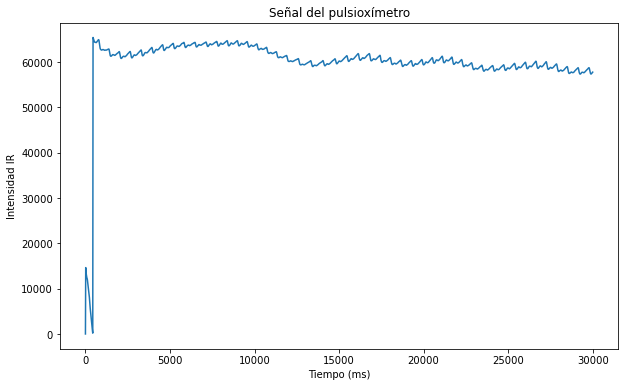

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo CSV
ruta_csv = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_99.csv"
df = pd.read_csv(ruta_csv)

# Mostrar las primeras filas
print(df.head())

# Graficar la señal IR para ver su forma
plt.figure(figsize=(10,6))
plt.plot(df["Tiempo (ms)"], df["IR"])
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad IR")
plt.title("Señal del pulsioxímetro")
plt.show()


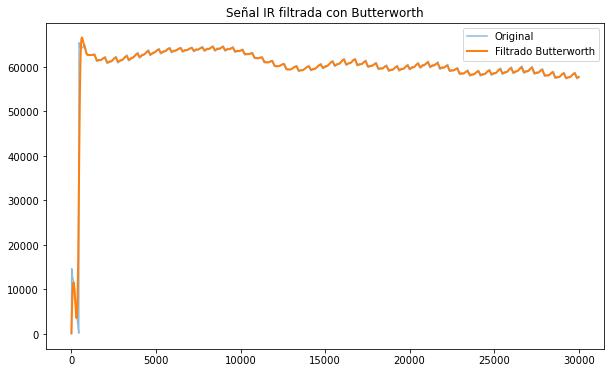

In [12]:
from scipy.signal import butter, filtfilt

# Función para aplicar un filtro pasa-bajos
def butter_lowpass_filter(data, cutoff=3, fs=35, order=2):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

df["IR_filtrado"] = butter_lowpass_filter(df["IR"], cutoff=3, fs=60)

plt.figure(figsize=(10,6))
plt.plot(df["Tiempo (ms)"], df["IR"], alpha=0.5, label="Original")
plt.plot(df["Tiempo (ms)"], df["IR_filtrado"], label="Filtrado Butterworth", linewidth=2)
plt.legend()
plt.title("Señal IR filtrada con Butterworth")
plt.show()


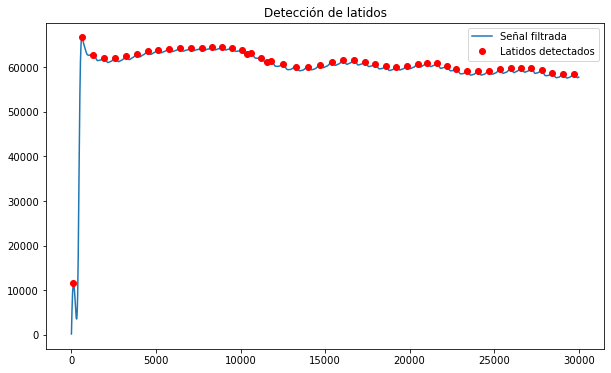

In [13]:
from scipy.signal import find_peaks

fs = 27  # Define la frecuencia de muestreo en Hz
        # Si deteccta pocos picos --> reducir fs
        # Si detecta muchos picos --
# Detectar los picos (latidos)
peaks, _ = find_peaks(df["IR_filtrado"], distance=fs/2, height=0.5)  # Ajusta 'height' según la amplitud

# Graficar los picos detectados
plt.figure(figsize=(10,6))

plt.plot(df["Tiempo (ms)"], df["IR_filtrado"], label="Señal filtrada")
plt.plot(df["Tiempo (ms)"][peaks], df["IR_filtrado"][peaks], "ro", label="Latidos detectados")
plt.legend()
plt.title("Detección de latidos")
plt.show()


In [14]:
import numpy as np

# Calcular los intervalos entre picos en segundos
intervalos = np.diff(df["Tiempo (ms)"][peaks]) / 1000  # Convertir ms a s

# Calcular BPM promedio
bpm = 60 / np.mean(intervalos)
print(f"Frecuencia cardíaca estimada: {bpm:.2f} BPM")


Frecuencia cardíaca estimada: 99.27 BPM


### Consigo estos resultados cambiando el valor de fs para cada set de datos, pero **¿Este ajuste de fs es generalizable o solo funciona para cada dataset individual?**

Para asegurar de que este ajuste funciona en general y no solo para casos específicos:

- Probar con más datasets

Si en otros archivos el error sigue siendo bajo, entonces fs está bien ajustado globalmente.
Si varía mucho, quizás necesitemos un método automático para optimizar fs en cada dataset.

- Revisar la estabilidad de los picos detectados

Mide la variabilidad en los intervalos entre picos.
Si hay mucha variación, quizás fs está compensando otro problema (como ruido o mala detección de picos).

- Explorar una optimización automática de fs

Podemos usar un bucle iterativo que pruebe varios valores de fs y minimice el error respecto al valor esperado.

El objetivo es encontrar automáticamente el valor óptimo de fs para minimizar el error en la estimación de la frecuencia cardíaca.

**Estrategia**

- Definir un rango de valores posibles para fs

Basándonos en las pruebas voy a empezar entre 20 Hz y 60 Hz.

- Aplicar el filtro Butterworth y detectar los picos

Para cada fs, aplicamos el filtrado y detectamos los latidos.

- Calcular la frecuencia cardíaca y comparar con el valor esperado

El error será la diferencia entre la frecuencia estimada y la esperada.
Busco el fs que minimice este error.

In [15]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks

def butter_bandpass_filter(data, lowcut=0.5, highcut=3, fs=50, order=2):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def calcular_frecuencia_cardiaca(df, fs):
    # Aplicamos el filtro
    df["IR_filtrado"] = butter_bandpass_filter(df["IR"], fs=fs)
    
    # Detectamos los picos (latidos)
    peaks, _ = find_peaks(df["IR_filtrado"], distance=fs/2, height=0.5)
    
    # Calculamos la frecuencia cardíaca
    tiempo_total = (df["Tiempo (ms)"].iloc[-1] - df["Tiempo (ms)"].iloc[0]) / 1000  # en segundos
    bpm_estimado = (len(peaks) / tiempo_total) * 60
    
    return bpm_estimado

def optimizar_fs(df, bpm_esperado, fs_min=15, fs_max=80, step=1):
    mejor_fs = None
    menor_error = float("inf")
    
    for fs in range(fs_min, fs_max + 1, step):
        bpm_estimado = calcular_frecuencia_cardiaca(df, fs)
        error = abs(bpm_estimado - bpm_esperado)
        
        if error < menor_error:
            menor_error = error
            mejor_fs = fs
            
    return mejor_fs, menor_error

#  USO DEL CÓDIGO
ruta_csv = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_80.csv"
df = pd.read_csv(ruta_csv)
bpm_esperado = 80  # Ajusta con el valor real del pulsioxímetro externo

mejor_fs, error = optimizar_fs(df, bpm_esperado)
bpm_estimado_final = calcular_frecuencia_cardiaca(df, mejor_fs)

print(f"Mejor fs encontrado: {mejor_fs} Hz")
print(f" Frecuencia cardíaca estimada: {bpm_estimado_final:.2f} BPM (Error: {error:.2f} BPM)")


Mejor fs encontrado: 41 Hz
 Frecuencia cardíaca estimada: 80.01 BPM (Error: 0.01 BPM)
